In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,f1_score
from sklearn.ensemble import GradientBoostingRegressor,BaggingClassifier,RandomForestRegressor ,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
!pip install scikit-learn
!pip install imbalanced-learn

In [6]:
train = pd.read_csv("Train-Set.csv\\Train-Set.csv")
train.head()


,Unnamed: 0,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,56963,31963,47,blue-collar,married,basic.9y,no,NaN,no,yes,cellular,apr,fri,583,2,999,1,failure,no
1,31753,21378,48,management,divorced,tertiary,no,351.0,yes,no,cellular,7,apr,725,3,-1,0,unknown,no
2,60854,17084,38,technician,single,high.school,no,NaN,no,no,cellular,aug,wed,74,2,999,0,nonexistent,no
3,34207,81693,50,management,divorced,tertiary,no,1270.0,yes,no,cellular,4,may,24,3,-1,0,unknown,no
4,73066,63978,54,self-employed,married,high.school,no,NaN,yes,yes,cellular,aug,thu,904,3,999,0,nonexistent,yes


In [7]:
test = pd.read_csv("Test-Set.csv\\Test-Set.csv")
test.head()

,Unnamed: 0,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,45247,74249,34,admin.,married,university.degree,no,NaN,no,no,cellular,jul,wed,266,1,999,0,nonexistent
1,19894,35779,31,management,single,tertiary,no,165.0,no,yes,cellular,8,aug,523,2,-1,0,unknown
2,70048,66769,28,blue-collar,single,basic.9y,no,NaN,no,no,telephone,may,fri,489,2,999,0,nonexistent
3,24241,27888,57,admin.,divorced,secondary,no,1878.0,yes,no,cellular,17,nov,219,1,-1,0,unknown
4,20495,63306,55,management,divorced,tertiary,no,277.0,no,no,cellular,12,aug,101,3,-1,0,unknown


train.drop('id',axis=1,inplace=True)

In [8]:
train.shape

(54712, 19)

# Data Wrangling

## Education:

1- Primary Education: Ages 6 to 12

2-Secondary Education:

    -Middle School or Junior High School: Ages 12 to 15.
    -High School: Ages 15 to 18.

3-Tertiary Education:

    -College or University: Ages 18 and above.

In [9]:
train.loc[train['education'] == 'professional.course', 'education'] = 'tertiary'
train.loc[train['education'] == 'basic.6y', 'education'] = 'secondary'
train.loc[train['education'] == 'basic.9y', 'education'] = 'secondary'
train.loc[train['education'] == 'basic.4y', 'education'] = 'primary'
train.loc[train['education'] == 'high.school', 'education'] = 'secondary'
train.loc[train['education'] == 'university.degree', 'education'] = 'tertiary'

#################################################################################

test.loc[test['education'] == 'professional.course', 'education'] = 'tertiary'
test.loc[test['education'] == 'basic.6y', 'education'] = 'secondary'
test.loc[test['education'] == 'basic.9y', 'education'] = 'secondary'
test.loc[test['education'] == 'basic.4y', 'education'] = 'primary'
test.loc[test['education'] == 'high.school', 'education'] = 'secondary'
test.loc[test['education'] == 'university.degree', 'education'] = 'tertiary'

In [10]:
train.education.value_counts()

secondary     26335
tertiary      18979
primary        7110
unknown        2276
illiterate       12
Name: education, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

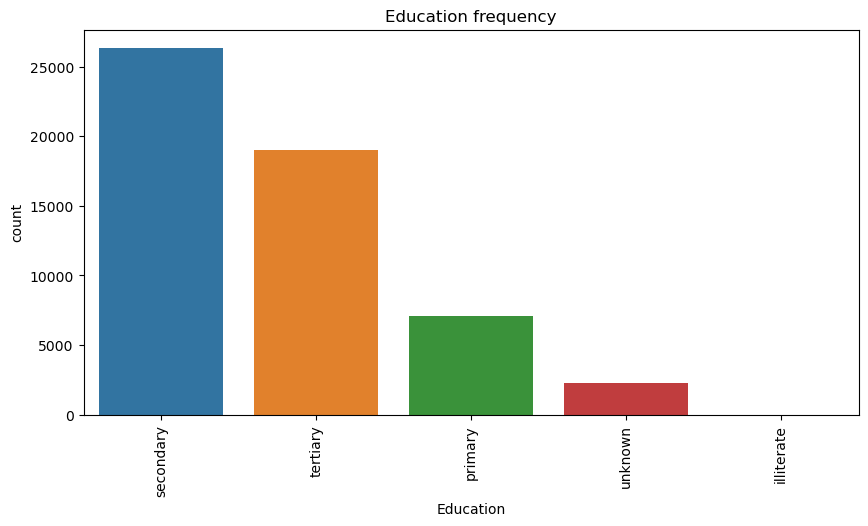

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x=train['education'])
plt.xlabel("Education")
plt.ylabel("count")
plt.title("Education frequency")
plt.xticks(rotation=90)
plt.show

## poutcome

train.loc[train['poutcome'] == 'other', 'poutcome'] = 'unknown'

#########################################################################

test.loc[test['poutcome'] == 'other', 'poutcome'] = 'unknown'

plt.figure(figsize=(10,5))
sns.countplot(x=train['poutcome'])
plt.xlabel("Poutcome")
plt.ylabel("count")
plt.title("Poutcome frequency")
plt.xticks(rotation=90)
plt.show

# Missing values:

## Housing & loan:

In [ ]:
print("housing values:",train.housing.value_counts())
print("loan values:",train.loan.value_counts())

In [ ]:
filtered=train.loc[(train['housing']=='unknown') & (train['loan']=='unknown')]
filtered.shape

**that means the unknown cells in housing is the unknown cells in loan.**

## Feature Engineering:

I do not care about if the customer has housing loan or other I am care about how many loan. so we can make feature engineering between two columns housing and loan as following:

1- if housing = yes and loan= no *or* housing = no and loan= yes *or* housing = yes and loan= unkown *or* housing = unknown and loan= yes  then number of loans are 1.

2- if housing = no and loan= no *or* housing = unknown and loan= no *or* housing = no and loan= unknown then number of loans are 0.

3- if housing = yes and loan= yes then number of loans are 2.

4- if housing = unkown and loan = unknown then number of loans are -1

In [ ]:
train.insert(8, 'number_of_loan', 0)
##################################################
test.insert(8, 'number_of_loan', 0)

In [ ]:
train.loc[(train['housing'] == 'yes') & (train['loan'] == 'yes'), 'number_of_loan'] = 2
train.loc[(train['housing'] == 'yes') & (train['loan'] == 'no'), 'number_of_loan'] = 1
train.loc[(train['housing'] == 'yes') & (train['loan'] == 'unknown'), 'number_of_loan'] = 1
train.loc[(train['housing'] == 'no') & (train['loan'] == 'yes'), 'number_of_loan'] = 1
train.loc[(train['housing'] == 'no') & (train['loan'] == 'no'), 'number_of_loan'] = 0
train.loc[(train['housing'] == 'no') & (train['loan'] == 'unknown'), 'number_of_loan'] = 0
train.loc[(train['housing'] == 'yes') & (train['loan'] == 'unknown'), 'number_of_loan'] =1
train.loc[(train['housing'] == 'unknown') & (train['loan'] == 'no'), 'number_of_loan'] =0
train.loc[(train['housing'] == 'unknown') & (train['loan'] == 'unknown'), 'number_of_loan'] =-1

##############################################################################################################

test.loc[(test['housing'] == 'yes') & (test['loan'] == 'yes'), 'number_of_loan'] = 2
test.loc[(test['housing'] == 'yes') & (test['loan'] == 'no'), 'number_of_loan'] = 1
test.loc[(test['housing'] == 'yes') & (test['loan'] == 'unknown'), 'number_of_loan'] = 1
test.loc[(test['housing'] == 'no') & (test['loan'] == 'yes'), 'number_of_loan'] = 1
test.loc[(test['housing'] == 'no') & (test['loan'] == 'no'), 'number_of_loan'] = 0
test.loc[(test['housing'] == 'no') & (test['loan'] == 'unknown'), 'number_of_loan'] = 0
test.loc[(test['housing'] == 'yes') & (test['loan'] == 'unknown'), 'number_of_loan'] =1
test.loc[(test['housing'] == 'unknown') & (test['loan'] == 'no'), 'number_of_loan'] =0
test.loc[(test['housing'] == 'unknown') & (test['loan'] == 'unknown'), 'number_of_loan'] =-1

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(x=train['number_of_loan'])
plt.xlabel("number_of_loan")
plt.ylabel("count")
plt.title("number_of_loan frequency")
plt.xticks(rotation=90)
plt.show

NameError: name 'plt' is not defined

**what is the relation between number of loan and the balance????**

In [16]:
train.loc[train['number_of_loan']==-1,['balance']]

,balance
73308,NaN
64752,NaN
63907,NaN
51427,NaN
55932,NaN
...,...
71007,NaN
62997,NaN
65323,NaN
58530,NaN


## Day

In [12]:
filtered_train = train[train['day'] == 'apr']
print(filtered_train['month'].value_counts())

thu    417
mon    376
fri    324
wed    178
tue    130
Name: month, dtype: int64


In [13]:
filtered_train = train[train['day'] == 'aug']
print(filtered_train['month'].value_counts())

thu    733
tue    700
wed    679
mon    663
fri    619
Name: month, dtype: int64


In [14]:
filtered_train = train[train['day'] == 'may']
print(filtered_train['month'].value_counts())

wed    1598
fri    1586
tue    1561
mon    1502
thu    1389
Name: month, dtype: int64


In [15]:
filtered_train = train[train['month'] == 'fri']
print(filtered_train['day'].value_counts())

may    1586
jun     653
aug     619
jul     577
nov     428
apr     324
oct      77
sep      70
mar      46
dec      13
Name: day, dtype: int64


In [16]:
filtered_train = train[train['month'] == 'mon']
print(filtered_train['day'].value_counts())

may    1502
jul     853
jun     695
aug     663
nov     415
apr     376
oct      76
mar      70
sep      47
dec      31
Name: day, dtype: int64


In [17]:
day_month_train=pd.DataFrame(train.loc[:,['day','month']])
day_month_test=pd.DataFrame(test.loc[:,['day','month']])

train.loc[train['day'] == 'apr', 'day'] = day_month_train.loc[day_month_train['day'] == 'apr', 'month']
train.loc[train['day'] == 'aug', 'day'] = day_month_train.loc[day_month_train['day'] == 'aug', 'month']
train.loc[train['day'] == 'may', 'day'] = day_month_train.loc[day_month_train['day'] == 'may', 'month']
train.loc[train['day'] == 'nov', 'day'] = day_month_train.loc[day_month_train['day'] == 'nov', 'month']
train.loc[train['day'] == 'dec', 'day'] = day_month_train.loc[day_month_train['day'] == 'dec', 'month']
train.loc[train['day'] == 'sep', 'day'] = day_month_train.loc[day_month_train['day'] == 'sep', 'month']
train.loc[train['day'] == 'jul', 'day'] = day_month_train.loc[day_month_train['day'] == 'jul', 'month']
train.loc[train['day'] == 'mar', 'day'] = day_month_train.loc[day_month_train['day'] == 'mar', 'month']
train.loc[train['day'] == 'jun', 'day'] = day_month_train.loc[day_month_train['day'] == 'jun', 'month']
train.loc[train['day'] == 'oct', 'day'] = day_month_train.loc[day_month_train['day'] == 'oct', 'month']

#########################################################################################################

test.loc[test['day'] == 'apr', 'day'] = day_month_test.loc[day_month_test['day'] == 'apr', 'month']
test.loc[test['day'] == 'aug', 'day'] = day_month_test.loc[day_month_test['day'] == 'aug', 'month']
test.loc[test['day'] == 'may', 'day'] = day_month_test.loc[day_month_test['day'] == 'may', 'month']
test.loc[test['day'] == 'nov', 'day'] = day_month_test.loc[day_month_test['day'] == 'nov', 'month']
test.loc[test['day'] == 'dec', 'day'] = day_month_test.loc[day_month_test['day'] == 'dec', 'month']
test.loc[test['day'] == 'sep', 'day'] = day_month_test.loc[day_month_test['day'] == 'sep', 'month']
test.loc[test['day'] == 'jul', 'day'] = day_month_test.loc[day_month_test['day'] == 'jul', 'month']
test.loc[test['day'] == 'mar', 'day'] = day_month_test.loc[day_month_test['day'] == 'mar', 'month']
test.loc[test['day'] == 'jun', 'day'] = day_month_test.loc[day_month_test['day'] == 'jun', 'month']
test.loc[test['day'] == 'oct', 'day'] = day_month_test.loc[day_month_test['day'] == 'oct', 'month']

In [18]:
train['day'][(train['day'] == 'fri')] ='6'
train['day'][(train['day'] == 'wed')] ='4'
train['day'][(train['day'] == 'tue')] ='3'
train['day'][(train['day'] == 'mon')] ='2'
train['day'][(train['day'] == 'thu')] ='5'

#########################################################################################################

test['day'][(test['day'] == 'fri')] ='6' 
test['day'][(test['day'] == 'wed')] ='4'
test['day'][(test['day'] == 'tue')] ='3'
test['day'][(test['day'] == 'mon')] ='2'
test['day'][(test['day'] == 'thu')] ='5'

<function matplotlib.pyplot.show(close=None, block=None)>

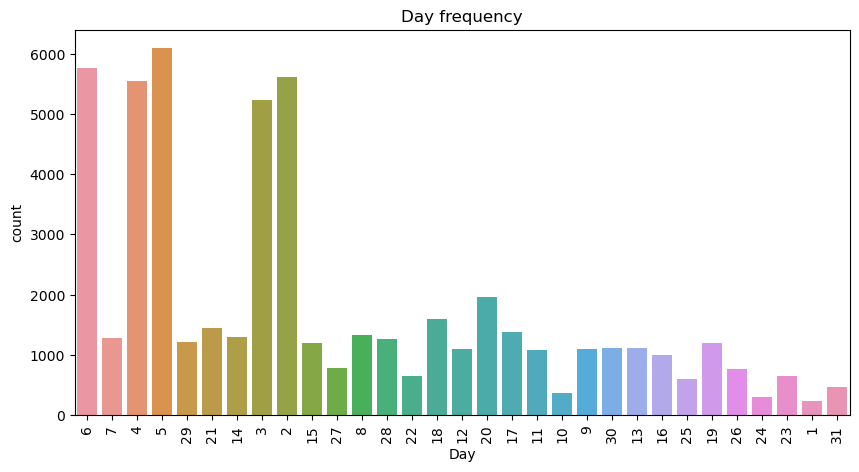

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x=train['day'])
plt.xlabel("Day")
plt.ylabel("count")
plt.title("Day frequency")
plt.xticks(rotation=90)
plt.show

## Month

In [20]:
train.loc[train['month'] == 'fri', 'month'] = day_month_train.loc[day_month_train['month'] == 'fri', 'day']
train.loc[train['month'] == 'wed', 'month'] = day_month_train.loc[day_month_train['month'] == 'wed', 'day']
train.loc[train['month'] == 'tue', 'month'] = day_month_train.loc[day_month_train['month'] == 'tue', 'day']
train.loc[train['month'] == 'mon', 'month'] = day_month_train.loc[day_month_train['month'] == 'mon', 'day']
train.loc[train['month'] == 'thu', 'month'] = day_month_train.loc[day_month_train['month'] == 'thu', 'day']


#########################################################################################################

test.loc[test['month'] == 'fri', 'month'] = day_month_test.loc[day_month_test['month'] == 'fri', 'day']
test.loc[test['month'] == 'wed', 'month'] = day_month_test.loc[day_month_test['month'] == 'wed', 'day']
test.loc[test['month'] == 'tue', 'month'] = day_month_test.loc[day_month_test['month'] == 'tue', 'day']
test.loc[test['month'] == 'mon', 'month'] = day_month_test.loc[day_month_test['month'] == 'mon', 'day']
test.loc[test['month'] == 'thu', 'month'] = day_month_test.loc[day_month_test['month'] == 'thu', 'day']


In [21]:
train['month'][(train['month'] == '2')] ='fep'
train['month'][(train['month'] == '3')] ='mar'
train['month'][(train['month'] == '4')] ='apr'
train['month'][(train['month'] == '5')] ='may'
train['month'][(train['month'] == '6')] ='jun'

#########################################################################################################

test['month'][(test['month'] == '2')] ='fep'
test['month'][(test['month'] == '3')] ='mar'
test['month'][(test['month'] == '4')] ='apr'
test['month'][(test['month'] == '5')] ='may'
test['month'][(test['month'] == '6')] ='jun'

<function matplotlib.pyplot.show(close=None, block=None)>

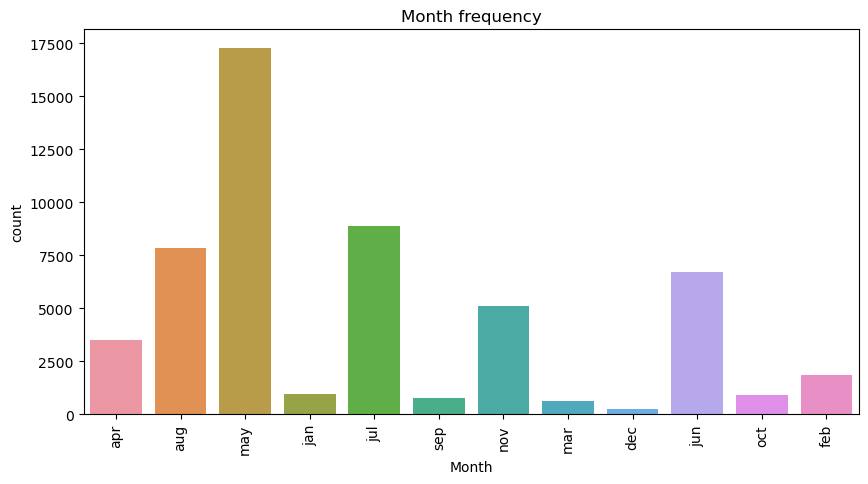

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x=train['month'])
plt.xlabel("Month")
plt.ylabel("count")
plt.title("Month frequency")
plt.xticks(rotation=90)
plt.show

# pdays

**Due to the data in the 'pdays' column being divided mostly between -1 and 999, we decided to create an alternative column named 'Pre-contact_the_customer' containing values 0 and 1. The value is 1 if it was previously contacted and 0 if it was not previously contacted.**

In [23]:
train_data=train.copy()

In [24]:
test_data=test.copy()

In [25]:
train_data['pdays'].value_counts()

-1      26054
 999    21996
 3        261
 6        251
 182      117
        ...  
 413        1
 562        1
 495        1
 592        1
 531        1
Name: pdays, Length: 526, dtype: int64

In [26]:
train_data.loc[(train_data['pdays']>=1),'pdays']=1
train_data.loc[(train_data['pdays']<1),'pdays']=0


test_data.loc[(train_data['pdays']>=1),'pdays']=1
test_data.loc[(train_data['pdays']<1),'pdays']=0

In [27]:
train_data['pdays'].value_counts()

1    28648
0    26064
Name: pdays, dtype: int64

In [28]:
train_data['Pre-contact_the_customer']=train_data['pdays']
train_data.drop(['pdays'],axis=1,inplace=True)

test_data['Pre-contact_the_customer']=test_data['pdays']
test_data.drop(['pdays'],axis=1,inplace=True)

In [29]:
train_data.head()

,Unnamed: 0,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,Target,Pre-contact_the_customer
0,56963,31963,47,blue-collar,married,secondary,no,NaN,no,yes,cellular,6,apr,583,2,1,failure,no,1
1,31753,21378,48,management,divorced,tertiary,no,351.0,yes,no,cellular,7,apr,725,3,0,unknown,no,0
2,60854,17084,38,technician,single,secondary,no,NaN,no,no,cellular,4,aug,74,2,0,nonexistent,no,1
3,34207,81693,50,management,divorced,tertiary,no,1270.0,yes,no,cellular,4,may,24,3,0,unknown,no,0
4,73066,63978,54,self-employed,married,secondary,no,NaN,yes,yes,cellular,5,aug,904,3,0,nonexistent,yes,1


## delet or filling missing value from balance column

<AxesSubplot:xlabel='job', ylabel='balance'>

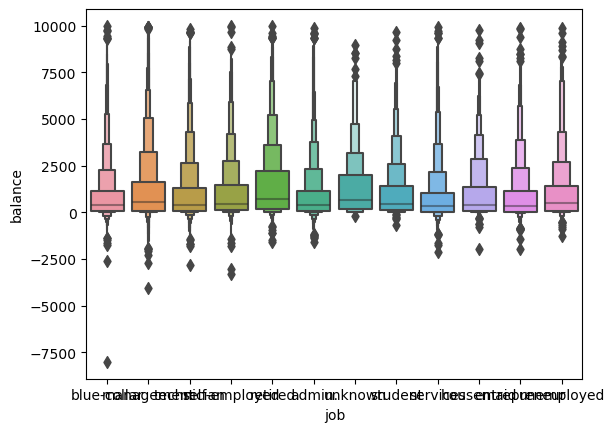

In [30]:
sns.boxenplot(data=train_data,x='job',y=train_data['balance'][train_data['balance']<10000])

**We cannot depend on the job column to fill missing values in the balance column**

<AxesSubplot:xlabel='age', ylabel='balance'>

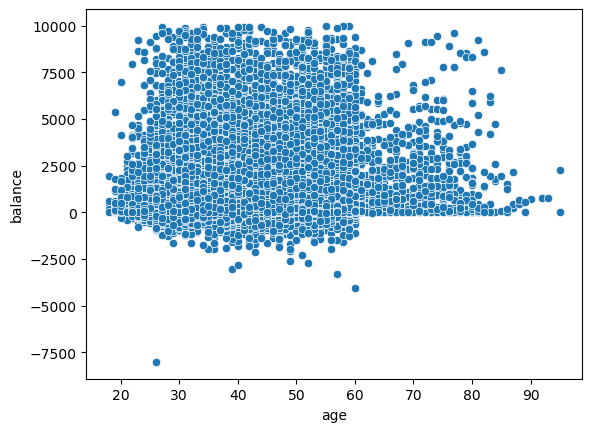

In [31]:
sns.scatterplot(data=train_data,x='age',y=train_data['balance'][train_data['balance']<10000])

<AxesSubplot:xlabel='education', ylabel='balance'>

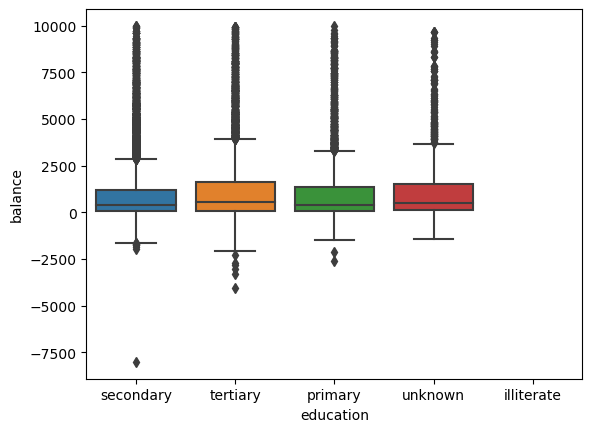

In [32]:
sns.boxplot(data=train_data,x='education',y=train_data['balance'][train_data['balance']<10000])

<AxesSubplot:xlabel='marital', ylabel='balance'>

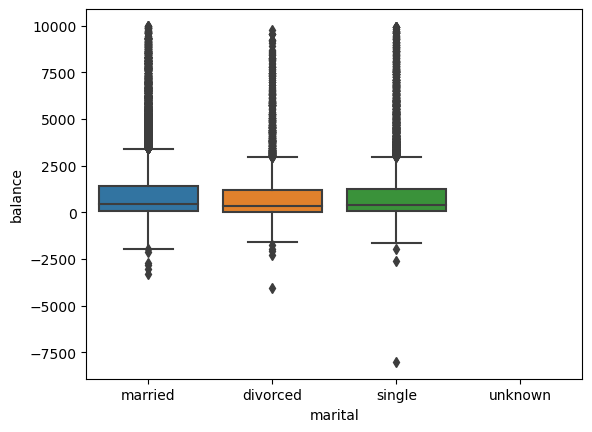

In [33]:
sns.boxplot(data=train_data,x='marital',y=train_data['balance'][train_data['balance']<10000])

<AxesSubplot:xlabel='Target', ylabel='balance'>

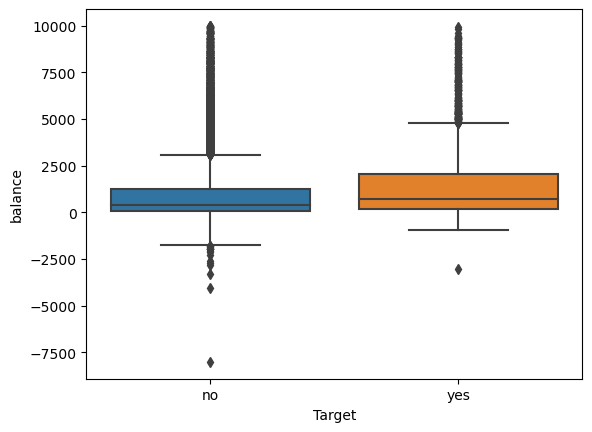

In [34]:
sns.boxplot(data=train_data,x='Target',y=train_data['balance'][train_data['balance']<10000])

In [35]:
# Create a contingency table between 'numeric_column' and 'categorical_column'
contingency_table = pd.crosstab(train_data['Target'], train_data['balance'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Value:", chi2)
print("p-value:", p_value)

Chi-Square Value: 8331.976336191368
p-value: 5.611359783684873e-60


**Therefore, based on the results, we can reject the null hypothesis of independence and conclude that there is a significant association between the two variables being tested using the Chi-Square test.**

In [36]:
train_data.shape

(54712, 19)

In [37]:
train_data['balance'].isna().sum()

22870

In [38]:
#train_data.dropna(subset=['balance'], inplace=True)

In [39]:
# Calculate the mean of the 'balance' column
balance_mean =train_data['balance'][train_data['balance']<10000].mean()

# Fill missing values in 'balance' column with the mean value
train_data['balance'].fillna(balance_mean, inplace=True)

balance_mean =test_data['balance'][test_data['balance']<10000].mean()
test_data['balance'].fillna(balance_mean, inplace=True)

In [40]:
train_data['balance'].isna().sum()

0

<AxesSubplot:xlabel='Target', ylabel='balance'>

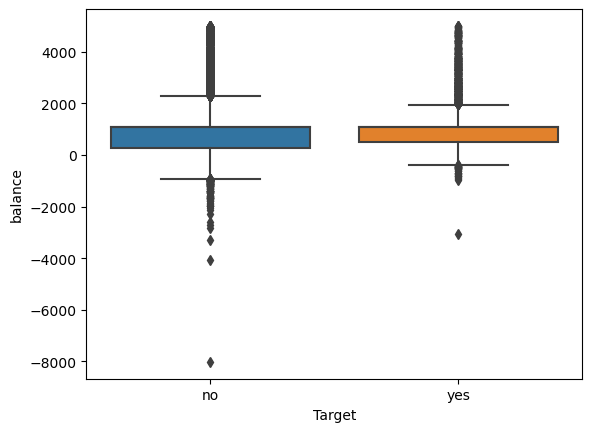

In [41]:
sns.boxplot(data=train_data,x='Target',y=train_data['balance'][train_data['balance']<5000])

In [42]:
# Create a contingency table between 'numeric_column' and 'categorical_column'
contingency_table = pd.crosstab(train_data['Target'], train_data['balance'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Value:", chi2)
print("p-value:", p_value)

Chi-Square Value: 8438.31566655656
p-value: 1.267675228840736e-65


# duration

 **Convert the 'duration' column from seconds to minutes**

In [43]:
train_data['duration']=train_data['duration'].apply((lambda x: round(x/60,1)))
train_data['duration']

0         9.7
1        12.1
2         1.2
3         0.4
4        15.1
         ... 
54707     3.9
54708    10.6
54709     4.3
54710     2.5
54711    17.6
Name: duration, Length: 54712, dtype: float64

In [44]:
test_data['duration']=test_data['duration'].apply((lambda x: round(x/60,1)))
test_data['duration']

0        4.4
1        8.7
2        8.2
3        3.6
4        1.7
        ... 
23444    3.4
23445    3.4
23446    9.8
23447    8.1
23448    1.6
Name: duration, Length: 23449, dtype: float64

# age 

**convert 'age' column is converted to a categorical column 'age_group' with specified age groups**

In [45]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['young', 'adult', 'middle-aged', 'senior', 'elderly']

# Create a new categorical column 'age_group' based on the bins
train_data['age_group'] = pd.cut(train_data['age'], bins=bins, labels=labels)

In [46]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['young', 'adult', 'middle-aged', 'senior', 'elderly']

# Create a new categorical column 'age_group' based on the bins
test_data['age_group'] = pd.cut(test_data['age'], bins=bins, labels=labels)

In [47]:
train_data.drop('age',axis=1,inplace=True)
test_data.drop('age',axis=1,inplace=True)
train_data

,Unnamed: 0,id,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,Target,Pre-contact_the_customer,age_group
0,56963,31963,blue-collar,married,secondary,no,1070.158358,no,yes,cellular,6,apr,9.7,2,1,failure,no,1,middle-aged
1,31753,21378,management,divorced,tertiary,no,351.000000,yes,no,cellular,7,apr,12.1,3,0,unknown,no,0,middle-aged
2,60854,17084,technician,single,secondary,no,1070.158358,no,no,cellular,4,aug,1.2,2,0,nonexistent,no,1,adult
3,34207,81693,management,divorced,tertiary,no,1270.000000,yes,no,cellular,4,may,0.4,3,0,unknown,no,0,middle-aged
4,73066,63978,self-employed,married,secondary,no,1070.158358,yes,yes,cellular,5,aug,15.1,3,0,nonexistent,yes,1,middle-aged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54707,21243,38468,management,married,tertiary,no,750.000000,yes,no,cellular,18,aug,3.9,12,0,unknown,no,0,adult
54708,45891,4378,services,married,secondary,no,1070.158358,no,no,telephone,4,may,10.6,6,0,nonexistent,no,1,adult
54709,42613,65128,management,married,tertiary,no,323.000000,no,no,cellular,11,jan,4.3,2,0,unknown,yes,0,adult
54710,43567,782,retired,married,secondary,no,616.000000,no,no,cellular,27,apr,2.5,2,1,failure,no,1,senior


# encoding 

In [48]:
columns=['job', 'marital', 'education', 'default', 'housing','loan', 'contact','day','month','Pre-contact_the_customer','age_group']

one_hot_encoded = pd.get_dummies(train_data[columns])

one_hot_encoded_test = pd.get_dummies(test_data[columns])
one_hot_encoded

,Pre-contact_the_customer,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month_mar,month_may,month_nov,month_oct,month_sep,age_group_young,age_group_adult,age_group_middle-aged,age_group_senior,age_group_elderly
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54707,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
54708,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
54709,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
54710,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
train_data.drop(['job', 'marital', 'education', 'default', 'housing','loan', 'contact','day','month','Pre-contact_the_customer','age_group'],axis=1,inplace=True)
test_data.drop(['job', 'marital', 'education', 'default', 'housing','loan', 'contact','day','month','Pre-contact_the_customer','age_group'],axis=1,inplace=True)

train_data=train_data.join(one_hot_encoded)
test_data=test_data.join(one_hot_encoded_test)
test_data

,Unnamed: 0,id,balance,duration,campaign,previous,poutcome,Pre-contact_the_customer,job_admin.,job_blue-collar,...,month_mar,month_may,month_nov,month_oct,month_sep,age_group_young,age_group_adult,age_group_middle-aged,age_group_senior,age_group_elderly
0,45247,74249,1058.922163,4.4,1,0,nonexistent,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,19894,35779,165.000000,8.7,2,0,unknown,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,70048,66769,1058.922163,8.2,2,0,nonexistent,1,0,1,...,0,1,0,0,0,0,1,0,0,0
3,24241,27888,1878.000000,3.6,1,0,unknown,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,20495,63306,277.000000,1.7,3,0,unknown,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23444,62765,902,1058.922163,3.4,5,0,nonexistent,0,0,1,...,0,1,0,0,0,0,1,0,0,0
23445,28615,39745,133.000000,3.4,3,0,unknown,1,0,0,...,0,0,0,0,0,0,0,1,0,0
23446,55510,40150,1058.922163,9.8,1,0,nonexistent,0,0,1,...,0,0,0,0,0,0,1,0,0,0
23447,53035,6012,1058.922163,8.1,2,0,nonexistent,1,0,0,...,0,0,1,0,0,0,0,1,0,0


# delet column

In [50]:
columns_to_remove = ['Unnamed: 0', 'id', 'poutcome']

# Using pop() in a loop to remove multiple columns
train_data = train_data.drop(columns=columns_to_remove)

#drop column from test data
test_data=test_data.drop(columns=columns_to_remove)


train_data=train_data.drop_duplicates()

In [51]:
train_data['Target'].value_counts()

no     48261
yes     6277
Name: Target, dtype: int64

# oversampling и undersampling  and modiling

## RandomForestClassifier

In [413]:
# Separate the target variable from the features
X = train_data.drop(columns=['Target'])
y = train_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resampling using SMOTETomek
smote_tomek = SMOTETomek(sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)



# Calculate class weights based on the class distribution
class_weights = dict(1 / y_train_resampled.value_counts())



# Train a machine learning model (e.g., Random Forest) on the resampled data
rf_regressor = RandomForestClassifier(n_estimators=100,class_weight=class_weights, max_depth=15, random_state=42)
rf_regressor.fit(X_train_resampled, y_train_resampled)
y_pred = rf_regressor.predict(X_test)


# Evaluate the model on the test set
f1 = f1_score(y_test, y_pred,pos_label='yes')
print("F1-Score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


F1-Score: 0.5500495540138751
Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.93      0.94     14497
         yes       0.51      0.60      0.55      1865

    accuracy                           0.89     16362
   macro avg       0.73      0.76      0.74     16362
weighted avg       0.90      0.89      0.89     16362

Confusion Matrix:
[[13436  1061]
 [  755  1110]]


# xgboost

In [52]:
# Separate the target variable from the features
X = train_data.drop(columns=['Target'])
y = train_data['Target']
y = y.map({'yes': 1, 'no': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resampling using SMOTETomek
smote_tomek = SMOTETomek(sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)



# Calculate class weights based on the class distribution
class_ratio = sum(y_train ==0) / sum(y_train == 1)


# Train a machine learning model (e.g., Random Forest) on the resampled data
xgb_model = xgb.XGBClassifier(n_estimators=100,scale_pos_weight=class_ratio, max_depth=15, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred = xgb_model.predict(X_test)


# Evaluate the model on the test set
f1 = f1_score(y_test, y_pred,pos_label=1)
print("F1-Score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

F1-Score: 0.5749068322981367
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     14497
           1       0.54      0.62      0.57      1865

    accuracy                           0.90     16362
   macro avg       0.74      0.78      0.76     16362
weighted avg       0.90      0.90      0.90     16362

Confusion Matrix:
[[13494  1003]
 [  708  1157]]


In [54]:
y_train_resampled.value_counts()

0    33527
1    33527
Name: Target, dtype: int64

# BaggingClassifier

In [435]:
# Separate the target variable from the features
X = train_data.drop(columns=['Target'])
y = train_data['Target']
y = y.map({'yes': 1, 'no': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resampling using SMOTETomek
smote_tomek = SMOTETomek(sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)



class_weights = {0: 1, 1: 5}

base_estimator = DecisionTreeClassifier(class_weight=class_weights)

# Initialize the Bagging Classifier
bagging_model = BaggingClassifier( n_estimators=100, random_state=42)

# Train the Bagging model on the training data
bagging_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_model.predict(X_test)



# Evaluate the model on the test set
f1 = f1_score(y_test, y_pred,pos_label=1)
print("F1-Score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

F1-Score: 0.5252403846153846
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     14497
           1       0.60      0.47      0.53      1865

    accuracy                           0.90     16362
   macro avg       0.77      0.71      0.74     16362
weighted avg       0.90      0.90      0.90     16362

Confusion Matrix:
[[13908   589]
 [  991   874]]


## predict test_data

In [436]:
y_pred = xgb_model.predict(test_data)
y_pred 

array([0, 0, 0, ..., 1, 0, 0])

In [437]:
SampleSubmition=pd.read_csv("Sample_Submition.csv")

In [438]:
SampleSubmition['Target']=y_pred
#SampleSubmition['Target'].replace({'yes': 1, 'no': 0}, inplace=True)

In [439]:
SampleSubmition.to_csv('Sample_Submition2.csv', index=False)

# balance

use xgboost to fill nan values in balance column.

In [142]:
data=train_data.drop(['Target','Unnamed: 0', 'id', 'poutcome'],axis=1)

In [144]:
#Split the data into training and test sets based on the missing values in the 'balance' column."

train_balance=data[(data['balance'].notna())]
test_balance=data[(data['balance'].isna())]
train_balance

,age,balance,duration,campaign,previous,Pre-contact_the_customer,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
1,48,351.0,725,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,1270.0,24,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,59,-411.0,225,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,28,222.0,125,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,67,2540.0,279,3,9,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,36,911.0,117,2,3,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
54706,22,23.0,137,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54707,35,750.0,233,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54709,35,323.0,261,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [150]:
test_balance

,age,balance,duration,campaign,previous,Pre-contact_the_customer,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,47,NaN,583,2,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,NaN,74,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,54,NaN,904,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,39,NaN,279,1,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,34,NaN,73,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54702,53,NaN,382,10,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
54704,59,NaN,143,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
54705,27,NaN,258,3,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
54708,31,NaN,636,6,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [166]:
# Separate the target variable from the features
X = train_balance.drop(columns=['balance'])
y = train_balance['balance']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=24)

rf_regressor = RandomForestRegressor(n_estimators=50,max_depth=10,min_samples_leaf=50, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# Calculate the Mean Squared Error to evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print('R-squared-test:', r2)

r1 = r2_score(y_train,rf_regressor.predict(X_train) )
print('R-squared-train:', r1)

Mean Squared Error: 8559152.69151525
R-squared-test: 0.03970764074573563
R-squared-train: 0.09050792156454268


In [168]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1,0.2,0.3]
}

# Create the model
gb_regressor = GradientBoostingRegressor()

# Initialize GridSearchCV with the model, hyperparameter grid, and cross-validation folds
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

print("Best Hyperparameters:", best_params)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print('R-squared-test:', r2)

r1 = r2_score(y_train,rf_regressor.predict(X_train) )
print('R-squared-train:', r1)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Mean Squared Error: 9597940.593966173
R-squared-test: -0.07683895230643123
R-squared-train: 0.09050792156454268


## balance

use KNNImputer to fill nan values in balance column.

from sklearn.impute import KNNImputer

train_imputed = train.copy()
train_imputed.drop('Target', axis=1, inplace=True)

# Initialize the KNNImputer with the number of neighbors (k) you want to consider.
# The default value of k is 5.
knn_imputer = KNNImputer(n_neighbors=5)

# Impute the missing 'balance' values
train_imputed['balance'] = knn_imputer.fit_transform(train[['balance']])

# The KNNImputer returns an array, so we need to convert it back to a DataFrame
# and assign the imputed values to the 'balance' column in the original DataFrame.
train_imputed = pd.DataFrame(train_imputed, columns=train.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

ax1.boxplot(x=train['balance'])
ax1.set_title('Boxplot for balance')

sns.distplot(train['balance'])
ax2.set_title('Histogram for balance')

# Add labels and titles
fig.suptitle('Distribution of balance')
ax1.set_ylabel('Value')
ax2.set_ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=train.balance)

a4_dims = (8,6)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(data=train, y="balance", x="Target")
ax.set_title("Distribution of the balance based on the target")